# Capstone Project - The Battle of Neighborhoods

## 1. Introduction

### 1.1 Background 

The trend of studying in Canada is getting more and more popular for International students. From the record, it shows that there are total 642.480 international students studied in Canada 2019[1]. There are 185% increase in international students in Canada from 2010 to 2019[1]. Nearly half of the students studied in Ontario and most of them studied in Toronto. 

Toronto is the largest city of Canada with the area of 630.2 square kilometers ,and population of 2,731,571. The rich culture diversity, colorful urban life, welcoming immigrants, increasing employment opportunity and high quality education make Toronto attract more and more international students.


### 1.2 Problem

As mentioned in Background Part, international student choose Toronto is not only for high quality education, also the culture and urban environment. Therefore, choosing a suitable place to live is first step. However, Increasing number of international students may increase the demand of house renting. 

Toronto is the first city ranked by population, but only 33rd by area in Canada. For city like Toronto with high population density, renting an apartment with a suitable price and good environment is not easy for students who knows little about the city. 

Therefore, I am going to investigate the data of Toronto Apartment Rental prices and venues info around the apartment, cluster the neighbors using k-means, predict the price of the apartment, and give the international students a best suggestion on renting an apartment.


### 1.3 Target audience

The target audiences of my project are: 
1.	Students who want to rent an apartment.
2.	Rental agency


## 2. Data

### 2.1 Data sources

The data resources I used in the project are listed as following:
1.	Toronto Apartment Rental prices: 
Kaggle: https://www.kaggle.com/rajacsp/toronto-apartment-price
The data consisted of number of bedroom, bathroom, address, latitude, longitude, and price of the apartment. Therefore, we can joint the data of apartment and the data of neighborhood, predict the rental price of the apartment, clustering the neighborhood and recommend a suitable neighborhood for student. 
2.	Foursquare location data: 
According to the geographical coordinates of University and apartments, the venues info around can be found. According to the venues around we can determine whether it is a good place for students to live. 
3.	Table of postal codes of Canada, 
Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.
Obtain the postal code and neighborhood of Toronto. 
4.	Geocoder package or the csv file 
Get the geographical coordinates according to postal code of Toronto.  


### 2.2 Data cleaning 

In [1]:
!pip install folium

import pandas as pd
import numpy as np
import requests 
from pandas.io.json import json_normalize
import os
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
%matplotlib inline

     |████████████████████████████████| 93 kB 3.9 MB/s  eta 0:00:01


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df=pd.read_html(url)[0]
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
R=df[df['Neighbourhood']=='Not assigned'].index
df['Neighbourhood'].replace('Not assigned',df['Borough'][R],inplace=True)
df.reset_index(drop=True)
Geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
df_Tor=df.merge(Geo_df,on='Postal Code')
df_Tor.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_Tor.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [4]:
toronto_data = df_Tor[df_Tor['Borough'].str.contains("Toronto",regex=False)].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [5]:
print('The size of tornoto data: ', toronto_data.shape)

The size of tornoto data:  (39, 5)


In [6]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_4ac7e27423104217b5327288845057c4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='tJYqUDdYvNHIa2ENWmelzbVi2tA0gKw7lM4XzKXJgEfv',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_4ac7e27423104217b5327288845057c4.get_object(Bucket='datasciencecapstone-donotdelete-pr-olr1fzgb7lejzy',Key='Toronto_apartment_rentals_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Apar_df = pd.read_csv(body)
Apar_df.rename(columns={'Lat':'Latitude', 'Long':'Longitude'},inplace=True)
Apar_df.head()


,Bedroom,Bathroom,Den,Address,Latitude,Longitude,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,"$2,450.00"
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,"$2,150.00"
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,"$1,950.00"
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,"$2,900.00"
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,"$1,800.00"


In [7]:
Apar_df['Price']=Apar_df['Price'].str.replace('$','')
Apar_df['Price']=Apar_df['Price'].str.replace(',','')
Apar_df['Price']=Apar_df['Price'].astype(float)
print('The size of apartment in toronto dataset:', Apar_df.shape)

The size of apartment in toronto dataset: (1124, 7)


In [8]:
Apar_df["PostalCode"] = Apar_df["Address"].str.extract(r"([A-Z]\d+[A-Z])")
Apar_df


,Bedroom,Bathroom,Den,Address,Latitude,Longitude,Price,PostalCode
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0,L5B
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0,M5V
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0,M5B
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0,M5J
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0,M5T
...,...,...,...,...,...,...,...,...
1119,3,1.0,0,", L7S 1R7, Burlington, ON",43.325233,-79.802182,3000.0,L7S
1120,1,1.0,0,", oakville L6M3V5 ON, Canada",43.445426,-79.736833,1200.0,L6M
1121,1,1.0,0,"Upper Beaches, Toronto, ON, Canada, M4C 1B4",43.683386,-79.309409,1800.0,M4C
1122,2,1.0,0,", Toronto M5B 2L7 ON, Canada",43.653636,-79.380873,2200.0,M5B


In [9]:
Num_Apar_postcode=Apar_df.groupby(['PostalCode']).mean()
Num_Apar_postcode

,Bedroom,Bathroom,Den,Latitude,Longitude,Price
PostalCode,,,,,,
H2X,1.000000,1.500000,0.000000,45.510566,-73.576385,1953.0
H3H,2.000000,1.000000,0.000000,45.492511,-73.580293,1475.0
K0K,1.000000,1.000000,0.000000,44.006022,-77.888152,1000.0
K9A,1.800000,1.500000,0.000000,43.961416,-78.166683,1270.0
L1A,1.000000,1.000000,1.000000,43.951428,-78.294416,1200.0
...,...,...,...,...,...,...
M9C,1.833333,1.666667,0.166667,43.614348,-79.559198,2290.0
M9N,1.818182,1.136364,0.000000,43.705037,-79.529629,1742.0
N1H,1.000000,1.000000,0.000000,43.544619,-80.247383,975.0


### linear regression

(0.0, 38700.0)

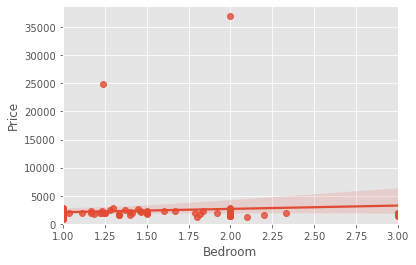

In [10]:
sns.regplot(x="Bedroom", y="Price", data=Num_Apar_postcode)
plt.ylim(0,)

(0.0, 38738.23300630201)

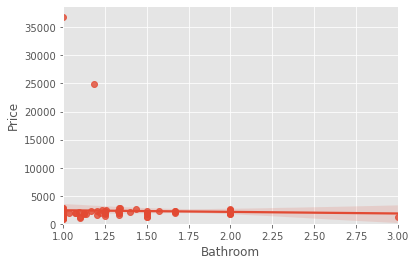

In [11]:
sns.regplot(x="Bathroom", y="Price", data=Num_Apar_postcode)
plt.ylim(0,)

(0.0, 38700.0)

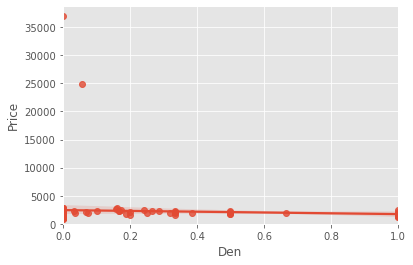

In [12]:
sns.regplot(x="Den", y="Price", data=Num_Apar_postcode)
plt.ylim(0,)

In [13]:

lm1 = LinearRegression()
X1=Num_Apar_postcode[['Bedroom','Bathroom','Den']]
y1=Num_Apar_postcode['Price']

X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2,random_state=4)
lm1.fit(X_train,y_train)


LinearRegression()

In [14]:
print(lm1.intercept_)
print(lm1.coef_)


2353.4320676094344
[ 1347.38340044 -1470.07971638  -479.71344876]


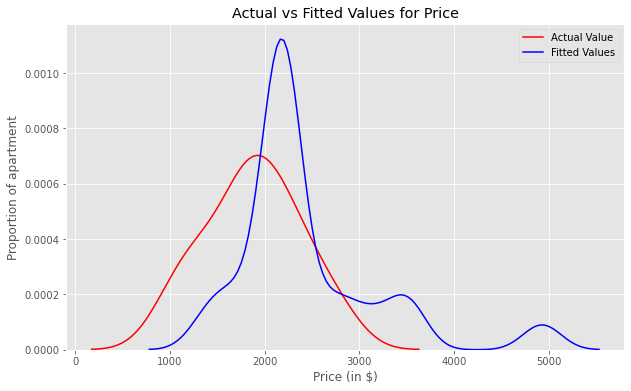

In [15]:
plt.figure(figsize=(10, 6))

Yhat=lm1.predict(X_test)

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in $)')
plt.ylabel('Proportion of apartment')

plt.show()
plt.close()

In [16]:
Num_Apar_postcode_mean=Num_Apar_postcode
Num_Apar_postcode_mean['Price']=Num_Apar_postcode_mean['Price']/Num_Apar_postcode_mean['Bedroom']
Num_Apar_postcode_mean=Num_Apar_postcode_mean.drop(['Bedroom','Bathroom','Den', 'Latitude','Longitude'],axis=1)
Num_Apar_postcode_mean.sort_values(['Price'],ascending=False,axis=0,inplace=True)

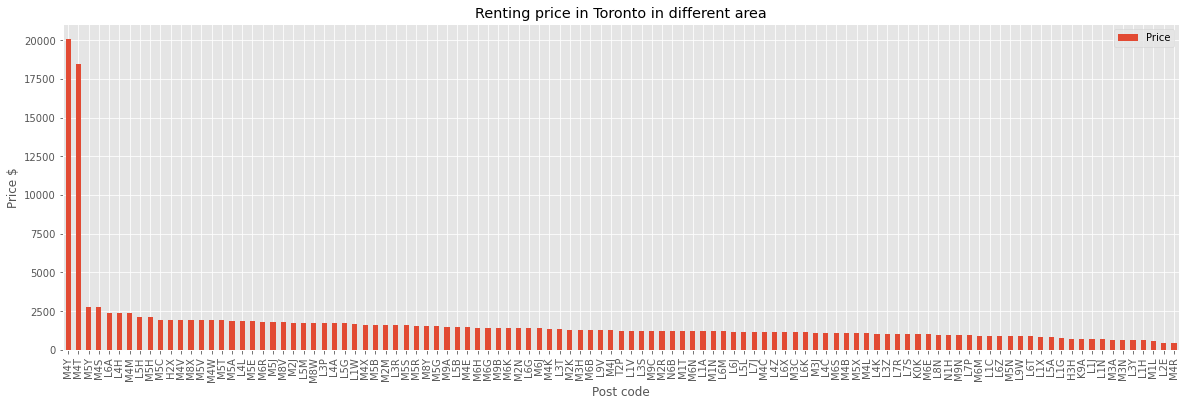

In [17]:

Num_Apar_postcode_mean.plot(kind='bar', figsize=(20, 6))
plt.title('Renting price in Toronto in different area')
plt.ylabel('Price $')
plt.xlabel('Post code')
plt.show()


In [18]:
Num_bed=Apar_df.groupby(['Bedroom']).mean()
Num_bed.head()

,Bathroom,Den,Latitude,Longitude,Price
Bedroom,,,,,
1,1.040721,0.22964,43.684187,-79.436786,4115.813084
2,1.610778,0.00000,43.678719,-79.493637,2600.898204
3,1.792683,0.00000,44.259074,-80.715592,3081.219512


In [19]:
Count_apar=Apar_df.groupby(['Bedroom']).count()
Count_apar.head()

,Bathroom,Den,Address,Latitude,Longitude,Price,PostalCode
Bedroom,,,,,,,
1,749,749,749,749,749,749,707
2,334,334,334,334,334,334,319
3,41,41,41,41,41,41,39


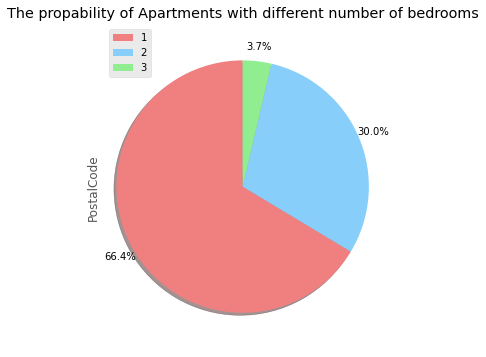

In [20]:
# autopct create %, start angle represent starting point
colors_list = [ 'lightcoral', 'lightskyblue', 'lightgreen']
Count_apar['PostalCode'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,    
                            shadow=True,       
                            labels=None, 
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list  # add custom colors
                           
                             )
plt.title('The propability of Apartments with different number of bedrooms')
plt.axis('equal') # Sets the pie chart to look like a circle.
plt.legend(labels=Count_apar.index, loc='upper left')
plt.show()

In [21]:
Apar_1Bed=Apar_df[Apar_df['Bedroom']==1].reset_index(drop=True)
Apar_1Bed.sort_values(['Price'],ascending=False,axis=0,inplace=True)

Apar_1Bed.head()

,Bedroom,Bathroom,Den,Address,Latitude,Longitude,Price,PostalCode
78,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0,M4Y
144,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0,M4Y
230,1,1.0,0,"101 Charles St, TORONTO, ON, M4Y 1V2",43.669593,-79.380580,535000.0,M4Y
432,1,1.0,0,"80 Blue Jays Way, Toronto, ON M5V 2G3, Canada",43.645297,-79.392397,4700.0,M5V
730,1,1.0,0,"8 York St, Toronto, ON M5J 2Y2, Canada",43.640646,-79.380939,4000.0,M5J


In [22]:
plot_bed1=Apar_1Bed.drop(['Bedroom','Bathroom','Den', 'Latitude','Longitude','Address'],axis=1)
plot_bed1.sort_values(by='Price',ascending=False,axis=0,inplace=True)
plot_bed1.set_index(['PostalCode'],drop=True,inplace=True)
plot_bed1.head()


,Price
PostalCode,
M4Y,535000.0
M4Y,535000.0
M4Y,535000.0
M5V,4700.0
M5J,4000.0


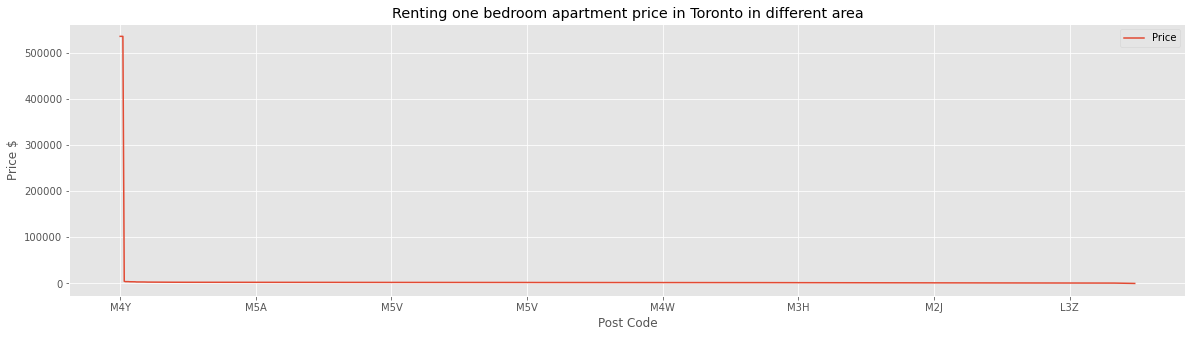

In [23]:
plot_bed1.plot(kind='line', figsize=(20, 5))
plt.title('Renting one bedroom apartment price in Toronto in different area')
plt.ylabel('Price $')
plt.xlabel('Post Code')
plt.show()

In [24]:
Apar_2Bed=Apar_df[Apar_df['Bedroom']==2].reset_index(drop=True)
Apar_2Bed.sort_values(by=['Price'],ascending=False,axis=0,inplace=True)
Apar_2Bed.head()

,Bedroom,Bathroom,Den,Address,Latitude,Longitude,Price,PostalCode
283,2,1.0,0,", TORONTO M4T 1P3 ON, Canada",43.690463,-79.381576,36900.0,M4T
292,2,2.5,0,"311 Bay St, Toronto, ON M5H 4G5, Canada",43.649783,-79.380440,9750.0,M5H
266,2,3.0,0,"180 University Ave, Toronto, ON M5H 0A2, Canada",43.648953,-79.385768,6500.0,M5H
312,2,2.0,0,"30 Nelson St, Toronto, ON M5V 0H5, Canada",43.649023,-79.388400,4500.0,M5V
194,2,2.0,0,"21 Nelson St, Toronto, ON M5V 3H9, Canada",43.648783,-79.388042,4100.0,M5V


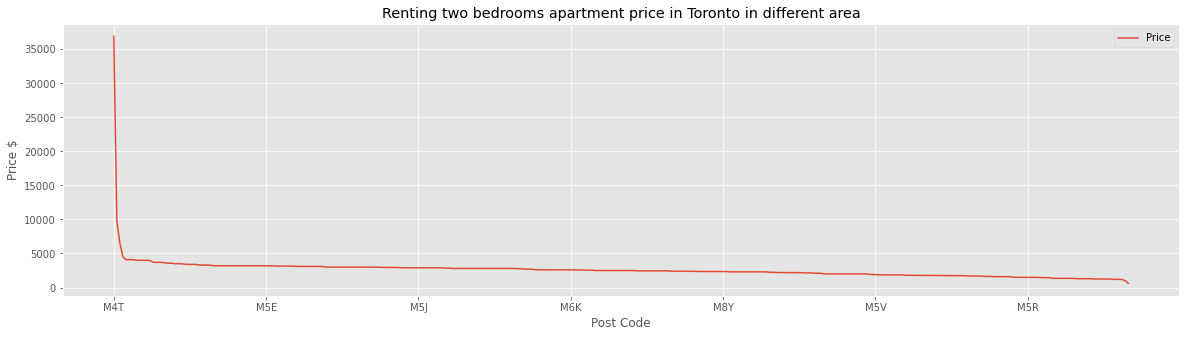

In [25]:
plot_bed2=Apar_2Bed.drop(['Bedroom','Bathroom','Den', 'Latitude','Longitude','Address'],axis=1)
plot_bed2.sort_values(by='Price',ascending=False,axis=0,inplace=True)
plot_bed2.set_index(['PostalCode'],drop=True,inplace=True)

plot_bed2.plot(kind='line', figsize=(20, 5))
plt.title('Renting two bedrooms apartment price in Toronto in different area')
plt.ylabel('Price $')
plt.xlabel('Post Code')
plt.show()

In [26]:
Apar_3Bed=Apar_df[Apar_df['Bedroom']==3].reset_index(drop=True)
Apar_3Bed.sort_values(by=['Price'],ascending=False,axis=0,inplace=True)
Apar_3Bed.head()

,Bedroom,Bathroom,Den,Address,Latitude,Longitude,Price,PostalCode
38,3,2.0,0,"21 Widmer St, Toronto, ON M5V 0B8, Canada",43.647226,-79.391100,8000.0,M5V
30,3,2.0,0,", toronto M5V 3z4 ON, Canada",43.641012,-79.394948,6000.0,M5V
35,3,3.0,0,"397 Front St W, Toronto, ON M5V 3S1, Canada",43.642569,-79.393460,4900.0,M5V
32,3,2.0,0,"14 York St, Toronto, ON M5J 0B1, Canada",43.641908,-79.381780,4900.0,M5J
16,3,2.0,0,"Salvador Allende Ct, Toronto, ON, M6G 0A3",43.672327,-79.428726,4625.0,M6G


In [27]:
Apartment_toronto_data=pd.merge(toronto_data,Num_Apar_postcode,on=['PostalCode'])
Apartment_toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude_x,Longitude_x,Bedroom,Bathroom,Den,Latitude_y,Longitude_y,Price
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.235294,1.250000,0.264706,43.654019,-79.363601,1886.345238
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1.459016,1.327869,0.032787,44.068058,-80.263063,1620.235955
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1.166667,1.166667,0.166667,43.651160,-79.375618,1953.571429
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,1.000000,1.000000,0.000000,43.679191,-79.287763,1450.000000
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.447368,1.434211,0.157895,43.645255,-79.376301,1854.545455


In [28]:
Neighbourhood_Apar=Apartment_toronto_data.groupby(['Neighbourhood'],as_index=False ).mean()


In [29]:


Neighbourhood_Apar.columns
Neighbourhood_Apar


,Neighbourhood,Latitude_x,Longitude_x,Bedroom,Bathroom,Den,Latitude_y,Longitude_y,Price
0,Berczy Park,43.644771,-79.373306,1.447368,1.434211,0.157895,43.645255,-79.376301,1854.545455
1,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,1.465116,1.093023,0.069767,43.639418,-79.425205,1414.269841
2,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,1.281407,1.233668,0.241206,43.643802,-79.394146,1943.462745
3,Central Bay Street,43.657952,-79.387383,1.222222,1.222222,0.037037,43.656788,-79.385487,1518.181818
4,Christie,43.669542,-79.422564,2.000000,1.333333,0.000000,43.668401,-79.420232,1420.833333
5,Church and Wellesley,43.665860,-79.383160,1.239437,1.183099,0.056338,43.842522,-79.762470,20051.988636
6,Davisville,43.704324,-79.388790,1.000000,1.000000,0.000000,43.698404,-79.394824,2800.000000
7,"Dufferin, Dovercourt Village",43.669005,-79.442259,1.187500,1.125000,0.187500,43.664819,-79.434812,1429.894737
8,"First Canadian Place, Underground city",43.648429,-79.382280,1.000000,1.000000,0.000000,43.648545,-79.381928,1100.000000
9,"Garden District, Ryerson",43.657162,-79.378937,1.459016,1.327869,0.032787,44.068058,-80.263063,1620.235955


In [30]:
Neighbourhood_Apar['Neighbourhood']

0                                           Berczy Park
1          Brockton, Parkdale Village, Exhibition Place
2     CN Tower, King and Spadina, Railway Lands, Har...
3                                    Central Bay Street
4                                              Christie
5                                  Church and Wellesley
6                                            Davisville
7                          Dufferin, Dovercourt Village
8                First Canadian Place, Underground city
9                              Garden District, Ryerson
10    Harbourfront East, Union Station, Toronto Islands
11                       India Bazaar, The Beaches West
12            Kensington Market, Chinatown, Grange Park
13                             Little Portugal, Trinity
14                          Moore Park, Summerhill East
15                    North Toronto West, Lawrence Park
16                               Parkdale, Roncesvalles
17                            Regent Park, Harbo

In [31]:
lm = LinearRegression()
X=Neighbourhood_Apar[['Bedroom','Bathroom','Den','Latitude_x','Longitude_x']]
y=Neighbourhood_Apar['Price']
lm.fit(X,y)
Yhat=lm.predict(X)

In [32]:
print(lm.intercept_)
print(lm.coef_)

-285913.4604083603
[ 7920.70928435 -8999.25365152  2026.76549623 28083.56955974
 11808.49450827]


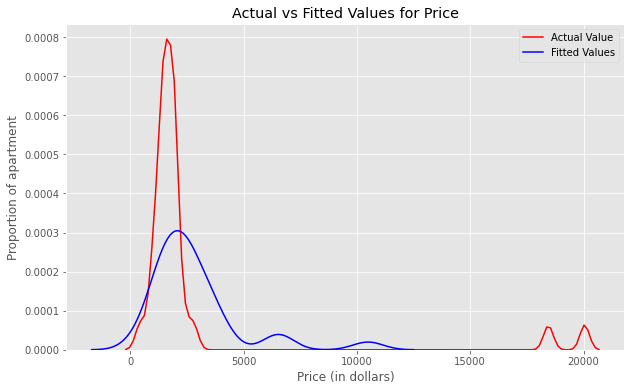

In [33]:
plt.figure(figsize=(10, 6))


ax1 = sns.distplot(Neighbourhood_Apar['Price'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of apartment')

plt.show()
plt.close()

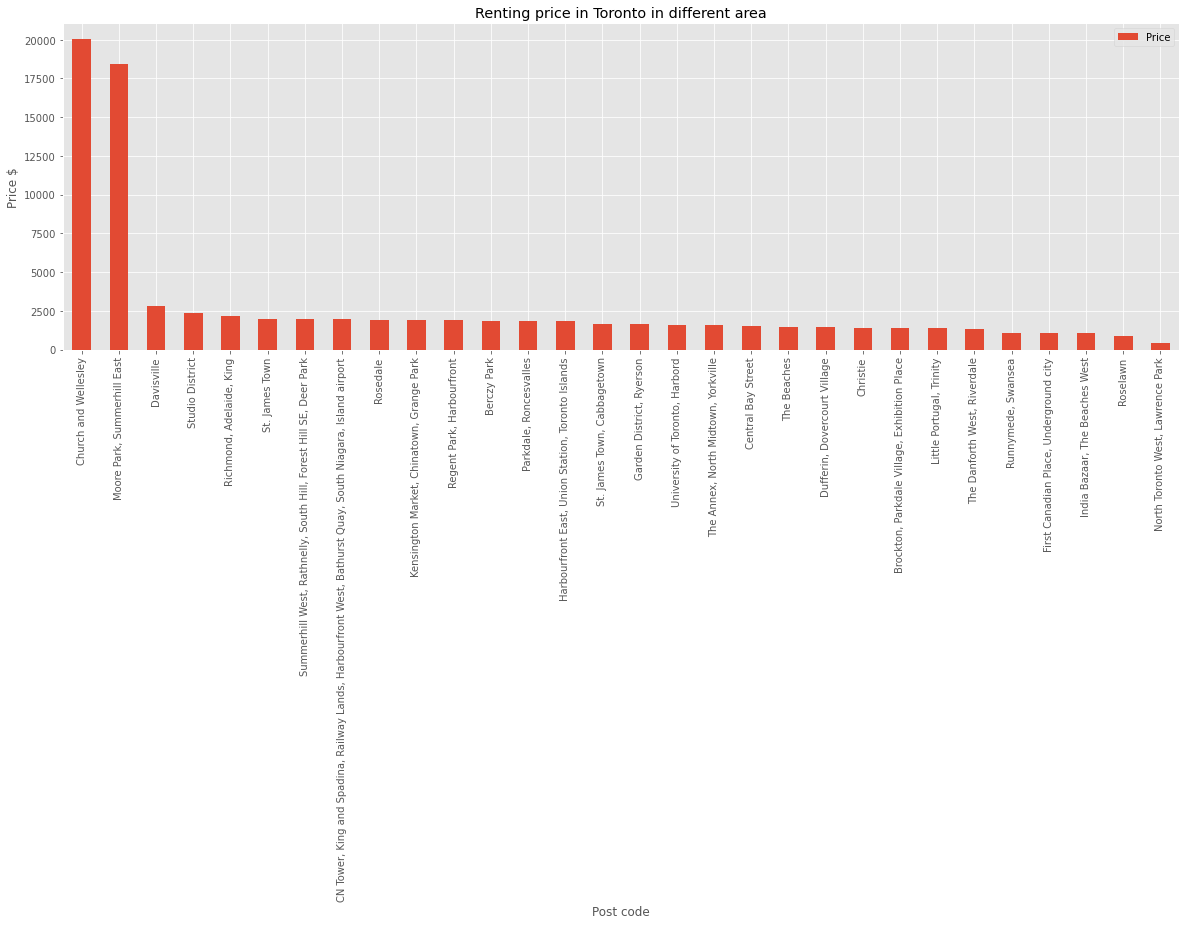

In [35]:
plot_N=Neighbourhood_Apar.drop(['Bedroom','Bathroom','Den', 'Latitude_x','Longitude_x','Latitude_y','Longitude_y'],axis=1)
plot_N.set_index(['Neighbourhood'],drop=True,inplace=True)
plot_N.sort_values(['Price'],ascending=False,axis=0,inplace=True)
plot_N.plot(kind='bar', figsize=(20, 6))
plt.title('Renting price in Toronto in different area')
plt.ylabel('Price $')
plt.xlabel('Post code')
plt.show()

In [36]:

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [37]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df_Tor['Latitude'], df_Tor['Longitude'], df_Tor['Borough'], df_Tor['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)      
map_Toronto

In [38]:

CLIENT_ID = 'BOS3WLIAS5DTC2CDMO4MKO5BRUCGGNYUGLFLCSY5YSLAAZ1O' # your Foursquare ID
CLIENT_SECRET = '2WQZRPVOR2LUZX2L0HPWMZAXCVFWCOOJXXYNV2YG41X4CEZ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BOS3WLIAS5DTC2CDMO4MKO5BRUCGGNYUGLFLCSY5YSLAAZ1O
CLIENT_SECRET:2WQZRPVOR2LUZX2L0HPWMZAXCVFWCOOJXXYNV2YG41X4CEZ2


In [39]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
       # print(requests.get(url).json())
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:

toronto_venues = getNearbyVenues(names=Neighbourhood_Apar['Neighbourhood'],
                                   latitudes=Neighbourhood_Apar['Latitude_y'],
                                   longitudes=Neighbourhood_Apar['Longitude_y']
                                  )

Berczy Park 43.6452547973684 -79.37630129210527
Brockton, Parkdale Village, Exhibition Place 43.639418079069756 -79.42520462325581
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport 43.64380178190954 -79.39414621256283
Central Bay Street 43.656788277777785 -79.3854870925926
Christie 43.66840053333333 -79.42023193333331
Church and Wellesley 43.84252151549294 -79.76246968028171
Davisville 43.69840429999999 -79.3948245
Dufferin, Dovercourt Village 43.66481941250001 -79.43481215625002
First Canadian Place, Underground city 43.64854455 -79.3819283
Garden District, Ryerson 44.06805769344259 -80.26306298524587
Harbourfront East, Union Station, Toronto Islands 43.64170224597701 -79.38094774252875
India Bazaar, The Beaches West 43.66792302500001 -79.313711975
Kensington Market, Chinatown, Grange Park 43.653429522222226 -79.39392504444446
Little Portugal, Trinity 43.643613769999995 -79.42159855999999
Moore Park, Summerhill East 43.6904633 -

In [41]:
Neighbourhood_Apar['Neighbourhood']

0                                           Berczy Park
1          Brockton, Parkdale Village, Exhibition Place
2     CN Tower, King and Spadina, Railway Lands, Har...
3                                    Central Bay Street
4                                              Christie
5                                  Church and Wellesley
6                                            Davisville
7                          Dufferin, Dovercourt Village
8                First Canadian Place, Underground city
9                              Garden District, Ryerson
10    Harbourfront East, Union Station, Toronto Islands
11                       India Bazaar, The Beaches West
12            Kensington Market, Chinatown, Grange Park
13                             Little Portugal, Trinity
14                          Moore Park, Summerhill East
15                    North Toronto West, Lawrence Park
16                               Parkdale, Roncesvalles
17                            Regent Park, Harbo


#toronto_venues = getNearbyVenues(names=Neighbourhood_Apar['Neighbourhood'],
                                   latitudes=Neighbourhood_Apar['Latitude_x'],
                                   longitudes=Neighbourhood_Apar['Longitude_x']
                                  )

In [42]:

# one hot encoding
Toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
#Toronto_onehot['Price']=toronto_venues['Price']
# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:

Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped.head()

,Neighbourhood,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.011111,0.0,0.0,0.011111,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.022222,0.000000,0.000000,0.0,0.000000,0.0,0.011111
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.017241,0.000000,0.017241,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.034483,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0,0.012821,0.000000,0.012821,0.0,0.000000,0.0,...,0.0,0.012821,0.0,0.012821,0.000000,0.000000,0.0,0.000000,0.0,0.012821
3,Central Bay Street,0.000000,0.0,0.0,0.012987,0.012987,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.012987,0.012987,0.0,0.012987,0.0,0.000000
4,Christie,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.083333,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Toronto_grouped.merge(right, Neighbourhood_Apar['Price'],on="Neighbourhood")
Toronto_grouped

In [61]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Sporting Goods Shop,Japanese Restaurant,Beer Bar,Café,Cocktail Bar,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Restaurant,Furniture / Home Store,Bar,Supermarket,Bakery,Gift Shop,Italian Restaurant,Vegetarian / Vegan Restaurant
2,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Restaurant,Hotel,Café,Pizza Place,Gym,Bar,Italian Restaurant,Japanese Restaurant,Grocery Store
3,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Hotel,Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Café,Department Store
4,Christie,Grocery Store,Café,Playground,Park,Athletics & Sports,Baby Store,Coffee Shop,Candy Store,Distribution Center,Event Space


In [63]:

# set number of clusters
kclusters = 5

tornoto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tornoto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
tornoto_grouped_clustering.head()

,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,...,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,0.011111,0.0,0.0,0.011111,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.022222,0.000000,0.000000,0.0,0.000000,0.0,0.011111
1,0.000000,0.0,0.0,0.017241,0.000000,0.017241,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.034483,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.0,0.012821,0.000000,0.012821,0.0,0.000000,0.0,0.000000,...,0.0,0.012821,0.0,0.012821,0.000000,0.000000,0.0,0.000000,0.0,0.012821
3,0.000000,0.0,0.0,0.012987,0.012987,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.012987,0.012987,0.0,0.012987,0.0,0.000000
4,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.083333,0.0,0.083333,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [66]:
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 1, 0, 3, 3, 1], dtype=int32)

In [83]:

# add clustering labels
neighborhoods_venues_sorted.insert(1, 'ClusterLabels', kmeans.labels_)

tornoto_merged = Neighbourhood_Apar

# merge two df to add latitude/longitude for each neighborhood
tornoto_merged = tornoto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

tornoto_merged.head()

ValueError: cannot insert ClusterLabels, already exists

In [73]:
tornoto_merged['ClusterLabels']=tornoto_merged['ClusterLabels'].fillna(5)

In [74]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tornoto_merged['Latitude_y'], tornoto_merged['Longitude_y'], tornoto_merged['Neighbourhood'], tornoto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [82]:
tornoto_merged.drop(['Latitude_x','Longitude_x','Cluster Labels'],axis=1,inplace=True)
tornoto_merged.head()

KeyError: "['Latitude_x' 'Longitude_x'] not found in axis"

In [81]:
tornoto_merged.loc[tornoto_merged['ClusterLabels'] == 0, tornoto_merged.columns[[1] + list(range(5, tornoto_merged.shape[1]))]]

KeyError: 'ClusterLabels'